<a href="https://colab.research.google.com/github/ahmadSum1/PythonRobotics/blob/skb_test/Localization/extended_kalman_filter/TTK33_EKF_IEKF_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

"""

Extended kalman filter (EKF) localization for asynchronus sensors

author: Sakib Ahmed (@ahmadSum1)
modified upon Atsushi Sakai (@Atsushi_twi) 's implementation

"""

In [ ]:
# Library imports

# import sys
# import pathlib
# sys.path.append(str(pathlib.Path(__file__).parent.parent.parent))

import math
# import matplotlib
# matplotlib.use('GTK3Agg')
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
# from enum import auto
import numpy as np
np.random.seed(0)

from scipy.spatial.transform import Rotation as Rot

In [ ]:
# mean=[0,0]
# cov=[[1, 0], [0, 1]]
# np.random.default_rng().multivariate_normal(mean, cov, (2,1)).shape

(2, 1, 2)

In [ ]:
## rotation function
def rot_mat_2d(angle):
    """
    Create 2D rotation matrix from an angle

    Parameters
    ----------
    angle :

    Returns
    -------
    A 2D rotation matrix
    """
    return Rot.from_euler('z', angle).as_matrix()[0:2, 0:2]


# Covariance for EKF simulation
Q = np.diag([
    0.1,  # variance of location on x-axis
    0.1,  # variance of location on y-axis
    np.deg2rad(1.0),  # variance of yaw angle
    0.5  # variance of velocity
    ]) ** 2  # predict state covariance
R = 10.25 * np.diag([1.0, 1.0]) ** 2  # Observation x,y position covariance

#  Simulation parameter
ODOM_NOISE = np.diag([1.0, np.deg2rad(30.0)]) ** 2
GPS_NOISE = np.diag([0.5, 0.5]) ** 2

f_odom = 100 #measurement frequency of velocity and yaw rate
f_gps = 1 #measurement frequency of position

DT = 1/f_odom  # time tick [s]


# show_animation = True

# genarates the trajectory
def calc_input(ccw=True):
    v = 1.0  # [m/s]
    if ccw:
        yawrate = 0.1  # [rad/s]
    else:
        yawrate = -0.1  # [rad/s]
    u = np.array([[v], [yawrate]])
    return u


def observation_IMU_Odom(xdr, u):
    
    # add noise to input
    ud = u + ODOM_NOISE @ np.random.normal( size=(2, 1))  #gaussian noise

    xdr = motion_model(xdr, ud)  #dead rekoning position

    return xdr, ud

def observation_z(xTrue):
    
    # add noise to gps x-y
    z = observation_model(xTrue) + GPS_NOISE @ np.random.normal( size=(2, 1))

    return z



def motion_model(x, u):
    F = np.array([[1.0, 0, 0, 0],
                  [0, 1.0, 0, 0],
                  [0, 0, 1.0, 0],
                  [0, 0, 0, 0]])

    B = np.array([[DT * math.cos(x[2, 0]), 0],
                  [DT * math.sin(x[2, 0]), 0],
                  [0.0, DT],
                  [1.0, 0.0]])

    x = F @ x + B @ u

    return x


def observation_model(x):
    H = np.array([
        [1, 0, 0, 0],
        [0, 1, 0, 0]
    ])

    z = H @ x

    return z


def jacob_f(x, u):
    """
    Jacobian of Motion Model

    motion model
    x_{t+1} = x_t+v*dt*cos(yaw)
    y_{t+1} = y_t+v*dt*sin(yaw)
    yaw_{t+1} = yaw_t+omega*dt
    v_{t+1} = v{t}
    so
    dx/dyaw = -v*dt*sin(yaw)
    dx/dv = dt*cos(yaw)
    dy/dyaw = v*dt*cos(yaw)
    dy/dv = dt*sin(yaw)
    """
    yaw = x[2, 0]
    v = u[0, 0]
    jF = np.array([
        [1.0, 0.0, -DT * v * math.sin(yaw), DT * math.cos(yaw)],
        [0.0, 1.0, DT * v * math.cos(yaw), DT * math.sin(yaw)],
        [0.0, 0.0, 1.0, 0.0],
        [0.0, 0.0, 0.0, 1.0]])

    return jF


def jacob_h():
    # Jacobian of Observation Model
    jH = np.array([
        [1, 0, 0, 0],
        [0, 1, 0, 0]
    ])

    return jH
    

In [ ]:
def plot_covariance_ellipse(xEst, PEst):  # pragma: no cover
    Pxy = PEst[0:2, 0:2]
    eigval, eigvec = np.linalg.eig(Pxy)

    if eigval[0] >= eigval[1]:
        bigind = 0
        smallind = 1
    else:
        bigind = 1
        smallind = 0

    t = np.arange(0, 2 * math.pi + 0.1, 0.1)
    a = math.sqrt(eigval[bigind])
    b = math.sqrt(eigval[smallind])
    x = [a * math.cos(it) for it in t]
    y = [b * math.sin(it) for it in t]
    angle = math.atan2(eigvec[1, bigind], eigvec[0, bigind])
    fx = rot_mat_2d(angle) @ (np.array([x, y]))
    px = np.array(fx[0, :] + xEst[0, 0]).flatten()
    py = np.array(fx[1, :] + xEst[1, 0]).flatten()
    plt.plot(px, py, "--r")


In [ ]:
def EKF_main(SIM_TIME=2.0, show_animation=False, show_covarience=False):
    print("EKF start!!")

    # time = 0.0

    # State Vector X=[x y yaw v]'
    xEst = np.zeros((4, 1))
    xTrue = np.zeros((4, 1))
    PEst = np.eye(4)

    xDR = np.zeros((4, 1))  # Dead reckoning

    # history
    hxEst = xEst
    hxTrue = xTrue
    hxDR = xTrue
    hz = np.zeros((2, 1))
    z = np.zeros((2, 1))

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(1, 1, 1)

    for k in range(int(SIM_TIME / DT)):

        # calculate/update real trjectory/pose every 10ms
        u = calc_input()  # * np.array([[1],[0]]) #real movement

        if k > SIM_TIME / DT / 2:  # change direction
            u = calc_input(ccw=False)

        xTrue = motion_model(xTrue, u)  # true position

        xDR, ud = observation_IMU_Odom(xDR, u)  # ud = measured movement/input; xDR = dead reckoning position, nothing to do with ekf, just for comparison;

        #  Predict
        xPred = motion_model(xEst, ud)  #previous state + input = current state(predicted)
        jF = jacob_f(xEst, ud)         
        PPred = jF @ PEst @ jF.T + Q  # P is covariace matrix of the state,

        # at GPS measurement freq
        if k % int(f_odom / f_gps) == 0:
            z = observation_z(xTrue)  # GPS data
            #  Update
            jH = jacob_h()
            zPred = observation_model(xPred)
            y = z - zPred
            S = jH @ PPred @ jH.T + R
            K = PPred @ jH.T @ np.linalg.inv(S)

            xEst = xPred + K @ y
            PEst = (np.eye(len(xEst)) - K @ jH) @ PPred  # P is covariace matrix of the state,
        else:                                            #(Fossen, 2021, sec. 13.4.4 Modification for Asynchronous Measurement Data)
            xEst = xPred
            PEst = PPred

        # store data history
        hxEst = np.hstack((hxEst, xEst))
        hxDR = np.hstack((hxDR, xDR))
        hxTrue = np.hstack((hxTrue, xTrue))
        hz = np.hstack((hz, z))

        # ax.set_xlim(auto=True)
        ax.cla()
        ax.plot(hz[0, :], hz[1, :], ".g", label="GPS")
        ax.plot(
            hxTrue[0, :].flatten(), hxTrue[1, :].flatten(), "-b", label="Ground Truth"
        )
        ax.plot(
            hxDR[0, :].flatten(), hxDR[1, :].flatten(), "-k", label="Dead Reckoning"
        )
        ax.plot(
            hxEst[0, :].flatten(),
            hxEst[1, :].flatten(),
            color="purple",
            ls="--",
            lw=1,
            marker="s",
            markerfacecolor="red",
            markersize=2,
            label="EKF",
        )

        if show_covarience:
            plot_covariance_ellipse(xEst, PEst)

        ax.axis("equal")
        ax.grid(True)
        ax.legend(loc="upper left")
        ax.set_title("Time = {:.2f}s".format(k * DT), fontsize="small", loc="left")
        if show_animation:
            # plt.pause(0.001)
            display(fig)

            clear_output(wait=True)
            # plt.pause(0.001)

    # display(fig)

In [ ]:
def iEKF_main(SIM_TIME=2.0, show_animation=False, show_covarience=False, max_iter=10):
    print("iEKF start!!")

    # State Vector X=[x y yaw v]'
    xEst = np.zeros((4, 1))
    xTrue = np.zeros((4, 1))
    PEst = np.eye(4)

    xDR = np.zeros((4, 1))  # Dead reckoning

    # define tolerance
    e = 1e-10

    # history
    hxEst = xEst
    hxTrue = xTrue
    hxDR = xTrue
    hz = np.zeros((2, 1))
    z = np.zeros((2, 1))

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(1, 1, 1)

    iter_hist = []

    for k in range(int(SIM_TIME / DT)):

        # calculate/update real trjectory/pose every 10ms
        u = calc_input()  # * np.array([[1],[0]]) #real movement

        if k > SIM_TIME / DT / 2:  # change direction
            u = calc_input(ccw=False)

        xTrue = motion_model(xTrue, u)  # true position

        xDR, ud = observation_IMU_Odom(xDR, u)  # ud = measured movement/input; xDR = dead reckoning position, nothing to do with ekf, just for comparison;

        #  Predict
        xPred = motion_model(xEst, ud)
        jF = jacob_f(xEst, ud)
        PPred = jF @ PEst @ jF.T + Q  # P is covariace matrix of the state,

        # at GPS measurement freq
        if k % int(f_odom / f_gps) == 0:
            z = observation_z(xTrue)  # GPS data
            #  Update

            # % initialize iterator using state estimation
            eta = xPred
            eta_l = np.zeros_like(eta)
            iter = 1

            while (
                np.linalg.norm(eta_l - eta, np.inf) / np.linalg.norm(eta_l, np.inf) >= e
            ) and (iter <= max_iter):

                # % save old eta at begin of loop, except at first iretation
                if iter != 0:
                    eta = eta_l

                jH = jacob_h()
                zPred = observation_model(eta)
                y = z - zPred
                S = jH @ PPred @ jH.T + R
                K = PPred @ jH.T @ np.linalg.inv(S)

                eta_l = xPred + K @ (y-jH@(xPred-eta)) # eq 63 from slide
                iter = iter + 1
            iter_hist.append(iter - 1)

            xEst = eta_l
            PEst = (np.eye(len(xEst)) - K @ jH) @ PPred  # P is covariace matrix of the state,

        else:
            xEst = xPred
            PEst = PPred

        # store data history
        hxEst = np.hstack((hxEst, xEst))
        hxDR = np.hstack((hxDR, xDR))
        hxTrue = np.hstack((hxTrue, xTrue))
        hz = np.hstack((hz, z))

        # ax.set_xlim(auto=True)
        ax.cla()
        ax.plot(hz[0, :], hz[1, :], ".g", label="GPS")
        ax.plot(
            hxTrue[0, :].flatten(), hxTrue[1, :].flatten(), "-b", label="Ground Truth"
        )
        ax.plot(
            hxDR[0, :].flatten(), hxDR[1, :].flatten(), "-k", label="Dead Reckoning"
        )
        ax.plot(
            hxEst[0, :].flatten(),
            hxEst[1, :].flatten(),
            color="purple",
            ls="-",
            lw=1,
            marker="s",
            markerfacecolor="red",
            markersize=2,
            label="EKF",
        )

        if show_covarience:
            plot_covariance_ellipse(xEst, PEst)

        ax.axis("equal")
        ax.grid(True)
        ax.legend(loc="upper left")
        ax.set_title("Time = {:.2f}s".format(k * DT), fontsize="small", loc="left")
        if show_animation:
            # plt.pause(0.001)
            display(fig)

            clear_output(wait=True)
            # plt.pause(0.001)

    print(iter_hist)  # for debug


In [ ]:
run_time = 3.2

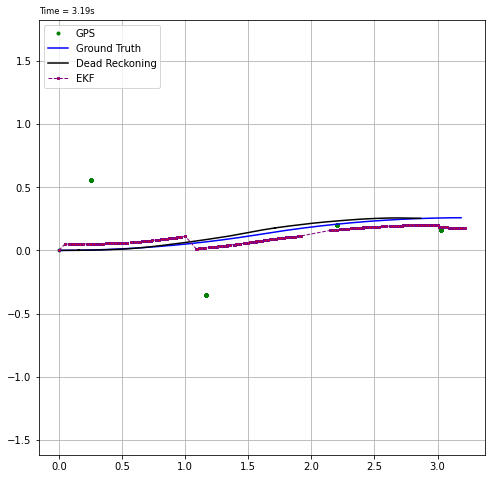

In [ ]:
np.random.seed(0)
EKF_main(SIM_TIME = run_time, show_animation = True, show_covarience = False)

[1, 1, 1, 1]


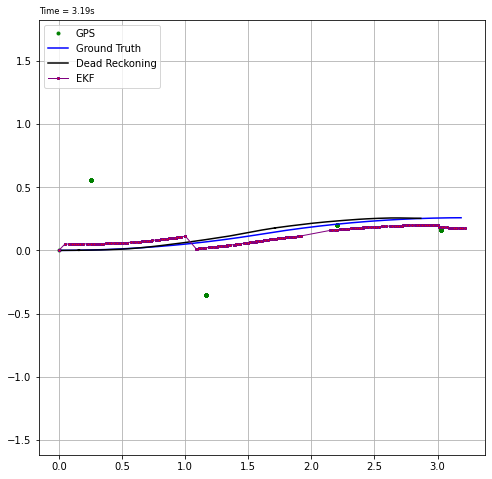

In [ ]:
np.random.seed(0)
iEKF_main(SIM_TIME = run_time, show_animation = True, show_covarience = False, max_iter=1) #should be same as "just ekf"

[2, 2, 2, 2]


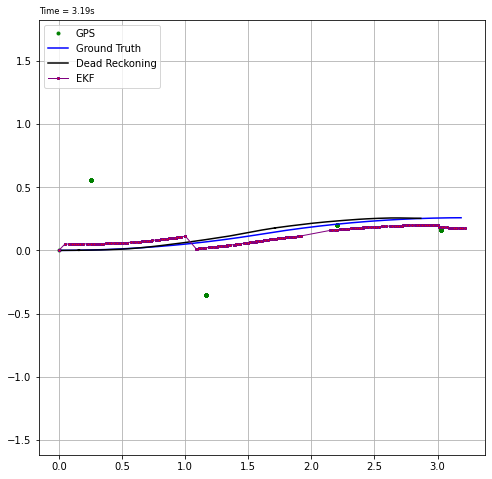

In [ ]:
np.random.seed(0)
iEKF_main(SIM_TIME = run_time, show_animation = True, show_covarience = False, max_iter=100)